### 0. Get the data

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import Freezer

In [4]:
torch.__version__

'0.4.1.post2'

### 2. Create PyTorch data generators

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

### 3. Create the network

In [6]:
model = models.resnet50(pretrained=True) 
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2),
               nn.Softmax(dim=-1))

In [7]:
net = NeuralNetClassifier(
    model,
    device='cuda',
    optimizer=optim.Adam,
    max_epochs=3,
    
    batch_size=32,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    
    train_split=predefined_split(image_datasets['validation']),

    callbacks=[
        Freezer(lambda name: not name.startswith('fc')),
    ]
)

### 4. Train the model

In [8]:
model_trained = net.fit(image_datasets['train'], None)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.9628       0.7550        0.4512  12.9627
      2        0.3840       0.9050        0.2672  12.9794
      3        0.2589       0.9250        0.2188  12.7646


### 5. Save and load the model

In [9]:
net.save_params('models/pytorch/weights.h5')

In [10]:
net.initialize()
net.load_params('models/pytorch/weights.h5')

### 6. Make predictions on sample test images

In [11]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [12]:
validation_batch = torch.stack([data_transforms['validation'](img)
                                for img in img_list])

In [13]:
pred_probs = net.predict_proba(validation_batch)

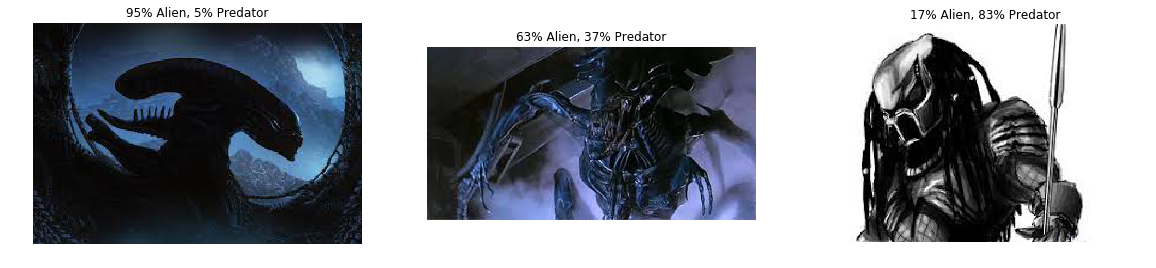

In [14]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)